In [3]:
# Importing necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from dataset import Dataset

In [10]:
data = Dataset('15min')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Estimation/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x =

In [15]:
data= pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv")
data.drop(columns=['Unnamed: 0', 'Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [16]:
# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
# print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)
features = len(cols) - 1  # Number of features


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
data = pd.concat([data, categorical_data], axis = 1)

X = data.drop(columns='Energy')
column_names = X.columns
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

train_data = xgb.DMatrix(X_train, label=Y_train)
val_data = xgb.DMatrix(X_val, label=Y_val)
test_data = xgb.DMatrix(X_test, label=Y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (val_data, 'eval')]

# Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=30000, evals=evals, early_stopping_rounds=200, verbose_eval=100)
y_pred = model.predict(test_data)

198.23530425829813
380.9409999996424
5.430999994277954
Train sizes:
(7425, 325) (7425, 1)
Validation sizes:
(655, 325) (655, 1)
Test sizes:
(656, 325) (656, 1)
[0]	train-rmse:0.29340	eval-rmse:0.30073


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:04:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722516643542/work/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.27874	eval-rmse:0.27919
[200]	train-rmse:0.26606	eval-rmse:0.26091
[300]	train-rmse:0.25504	eval-rmse:0.24479
[400]	train-rmse:0.24551	eval-rmse:0.23097
[500]	train-rmse:0.23706	eval-rmse:0.21791
[600]	train-rmse:0.22965	eval-rmse:0.20607
[700]	train-rmse:0.22303	eval-rmse:0.19570
[800]	train-rmse:0.21707	eval-rmse:0.18548
[900]	train-rmse:0.21160	eval-rmse:0.17541
[1000]	train-rmse:0.20662	eval-rmse:0.16636
[1100]	train-rmse:0.20217	eval-rmse:0.15909
[1200]	train-rmse:0.19804	eval-rmse:0.15292
[1300]	train-rmse:0.19427	eval-rmse:0.14753
[1400]	train-rmse:0.19094	eval-rmse:0.14265
[1500]	train-rmse:0.18794	eval-rmse:0.13808
[1600]	train-rmse:0.18506	eval-rmse:0.13398
[1700]	train-rmse:0.18216	eval-rmse:0.13040
[1800]	train-rmse:0.17949	eval-rmse:0.12653
[1900]	train-rmse:0.17710	eval-rmse:0.12383
[2000]	train-rmse:0.17491	eval-rmse:0.12161
[2100]	train-rmse:0.17299	eval-rmse:0.11944
[2200]	train-rmse:0.17117	eval-rmse:0.11751
[2300]	train-rmse:0.16952	eval-rmse:0.115

# XGBoost

In [17]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 37))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler_Y.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],37))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[i]
    
original = scaler_Y.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 33.160241234291824
Root Mean Squared Error (RMSE): 49.18024043300475
R² Score: 0.8359210454096451
Adjusted R² Score: 0.6743281355858106


/tmp/ipykernel_4862/4104576273.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


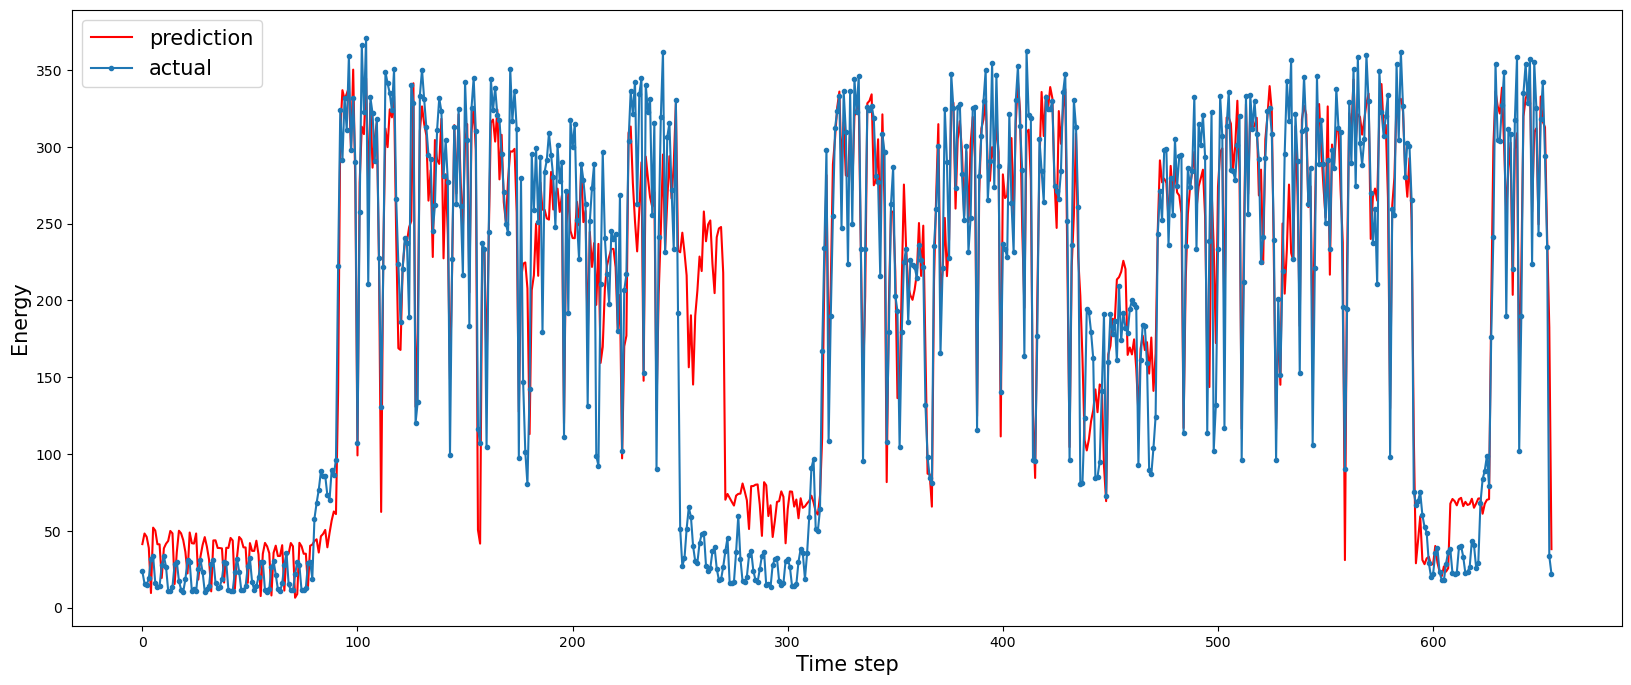

In [20]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='prediction', color="r")
plt.plot(original, label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

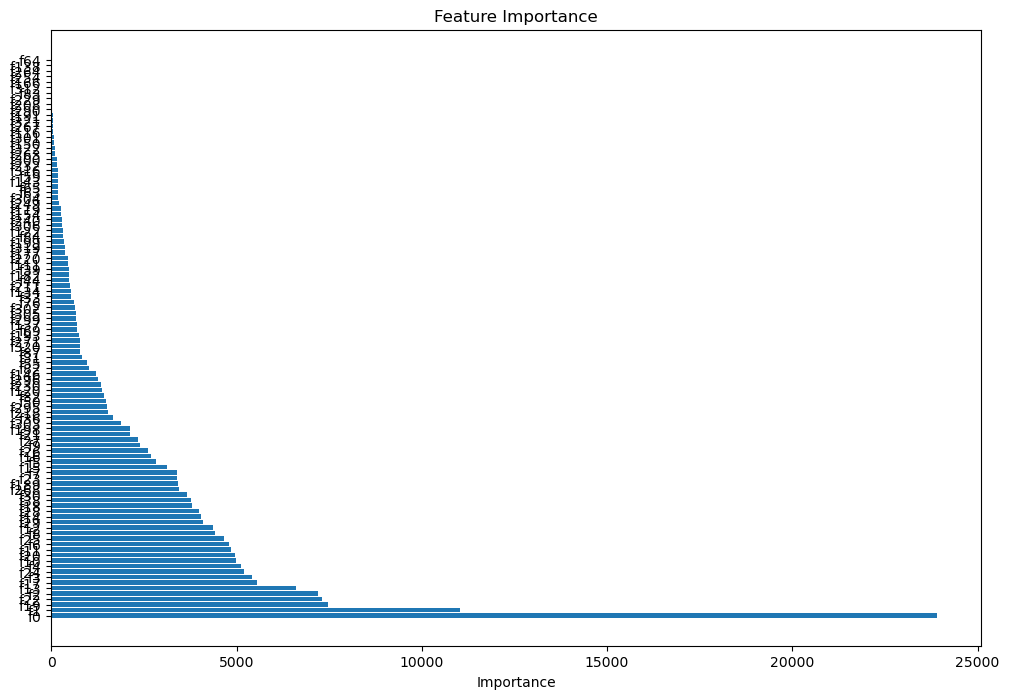

In [9]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

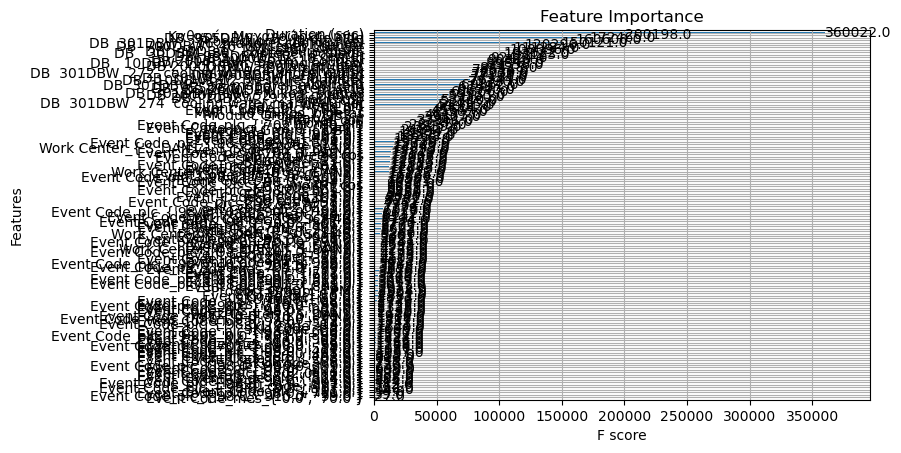

In [34]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()


In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_combined)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_combined)

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Step 6: Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Step 8: Evaluate the model using Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

# Step 9: Feature Importance (which features contribute the most to energy prediction)
feature_importances = rf_model.feature_importances_
features = df.drop(columns=['diff']).columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Energy Prediction')
plt.show()

# Step 11: (Optional) Plot a comparison of true vs predicted energy consumption
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('True Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('True vs Predicted Energy Consumption')
plt.show()


KeyboardInterrupt: 